## 1. Load Data

In [83]:

import numpy as np

# Load npz
data = np.load("../data/iris_data.npz")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

print(f"Training X shape: {X_train.shape}, y shape: {y_train.shape}")
print(f"Testing X shape: {X_test.shape}, y shape: {y_test.shape}")

Training X shape: (64, 4), y shape: (64,)
Testing X shape: (36, 4), y shape: (36,)


## 2. Traiable Quantum Feature Map

In [84]:
#!/usr/bin/env python3
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))



In [74]:
# update last change
import importlib
import src.feature_map
importlib.reload(src.feature_map)
import numpy as np

from src.feature_map import TrainableQuantumFeatureMap


# Train the feature map
depth = 1
tqfm = TrainableQuantumFeatureMap(depth=depth, optimizer='COBYLA', maxiter=100)
tqfm.fit(X_train, y_train, type="EfficientSU2")


In [75]:
tqfm.get_optimal_value()

np.float64(0.214236726073189)

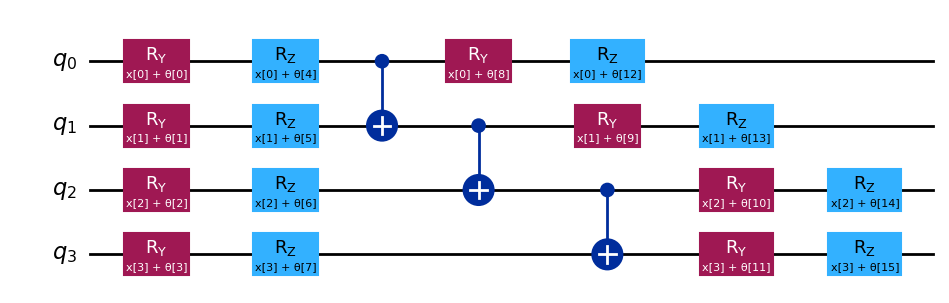

In [76]:
tqfm.circuit.draw('mpl')

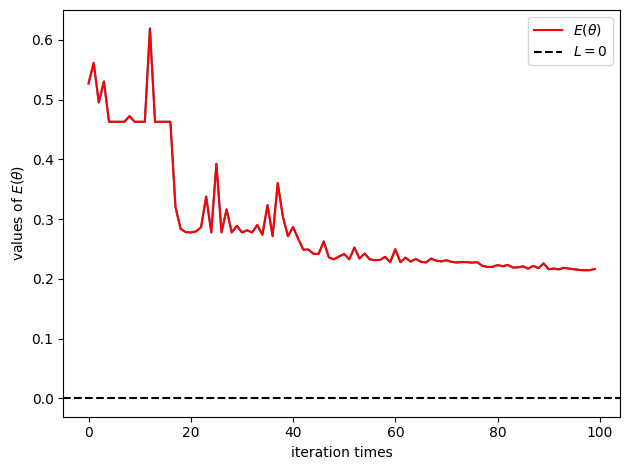

In [77]:
tqfm.plot_loss()

## 3. Kernel Matrix

In [78]:
# update last change
import importlib
import src.kernel_estimate
importlib.reload(src.kernel_estimate)

from src.kernel_estimate import KernelMatrix

kernel_before = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm.init_theta, tqfm.circuit)
kernel_after = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm.optimal_params, tqfm.circuit)
kernel_test = KernelMatrix.compute_kernel_matrix_with_inner_products(X_test, X_train, tqfm.optimal_params, tqfm.circuit)

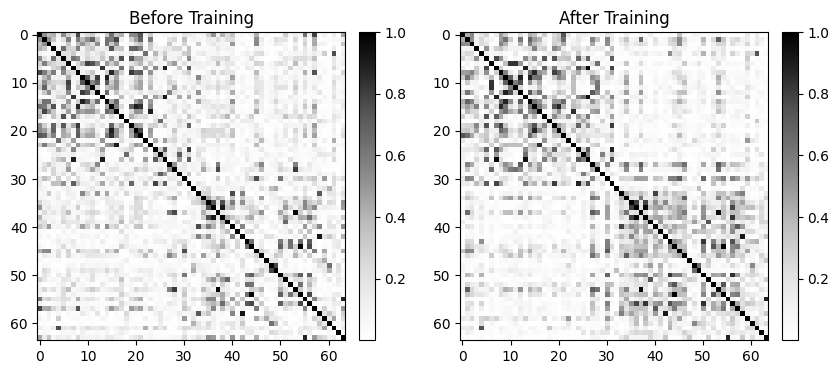

In [79]:
KernelMatrix.plot_multi_kernel_matrices([kernel_before, kernel_after],
										titles=['Before Training', 'After Training'],)

## 4. Analysis

This counterintuitive result reveals important insights about quantum feature map training:

In [80]:
# Deep kernel analysis
print("="*60)
print("KERNEL QUALITY ANALYSIS")
print("="*60)


# Class separability analysis
mask = ~np.eye(kernel_before.shape[0], dtype=bool)
print(f"\nClass Separability Analysis:")
print(f"Training set: {np.sum(y_train == -1)} class -1, {np.sum(y_train == 1)} class 1")

# Compute within-class and between-class similarities
class_0_idx = np.where(y_train == -1)[0]
class_1_idx = np.where(y_train == 1)[0]

# Within-class similarity (should be high)
within_0_before = kernel_before[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_before = kernel_before[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()
within_0_after = kernel_after[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_after = kernel_after[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()

# Between-class similarity (should be low)
between_before = kernel_before[np.ix_(class_0_idx, class_1_idx)].mean()
between_after = kernel_after[np.ix_(class_0_idx, class_1_idx)].mean()

print(f"Within-class similarity:")
print(f"  Class -1: BEFORE={within_0_before:.4f}, AFTER={within_0_after:.4f}")
print(f"  Class +1: BEFORE={within_1_before:.4f}, AFTER={within_1_after:.4f}")
print(f"Between-class similarity:")
print(f"  BEFORE={between_before:.4f}, AFTER={between_after:.4f}")

# 5. Separability ratio
sep_ratio_before = (within_0_before + within_1_before) / (2 * between_before)
sep_ratio_after = (within_0_after + within_1_after) / (2 * between_after)
print(f"\nSeparability ratio (within/between, higher is better):")
print(f"BEFORE: {sep_ratio_before:.4f}")
print(f"AFTER:  {sep_ratio_after:.4f}")
print(f"Change: {((sep_ratio_after - sep_ratio_before)/sep_ratio_before)*100:+.2f}%")

KERNEL QUALITY ANALYSIS

Class Separability Analysis:
Training set: 32 class -1, 32 class 1
Within-class similarity:
  Class -1: BEFORE=0.2333, AFTER=0.2347
  Class +1: BEFORE=0.1676, AFTER=0.2156
Between-class similarity:
  BEFORE=0.1072, AFTER=0.0905

Separability ratio (within/between, higher is better):
BEFORE: 1.8704
AFTER:  2.4869
Change: +32.96%


In [81]:
# Save the trained quantum feature map circuit
import pickle
with open(f"../data/tqfm_depth{depth}_iris.pkl", "wb") as f:
	pickle.dump(tqfm, f)

In [82]:
# Save kernel matrix to file
np.save('../data/kernel_matrix_before_iris.npy', kernel_before)
np.save('../data/kernel_matrix_after_iris.npy', kernel_after)
np.save('../data/kernel_matrix_test_iris.npy', kernel_test)